In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing import graph_dict
from AttentiveFP.AttentiveLayers_new import Fingerprint, graph_dataset, null_collate, Graph, Logger, time_to_str



In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

if cuda_aviable:
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.deterministic = True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  9999
number of successfully processed smiles:  9999


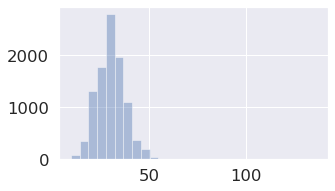

In [4]:
task_name = 'Malaria Bioactivity'
tasks = ['Loge EC50']

raw_filename = "../data/malaria-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename, names = ["Loge EC50", "smiles"])
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
random_seed = 888 # 69，103, 107
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 128

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
radius = 2
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smiles_list = smiles_tasks_df['smiles'].values
label_list = smiles_tasks_df[tasks[0]].values
graph_dict = graph_dict(smiles_list, label_list, filename)


graph dicts loaded from ../data/malaria-processed.pkl


In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=88)
train_fold = []
valid_fold = []
for k, (train_idx, valid_idx) in enumerate(kfold.split(smiles_list)):
    train_fold.append(train_idx)
    valid_fold.append(valid_idx)
    

In [8]:
loss_function = nn.MSELoss()
model = Fingerprint(num_target=output_units_num, fingerprint_dim=16, K=4, T=2, p_dropout=p_dropout)
model.to(device)

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

24583
preprocess.0.linear.weight torch.Size([16, 39])
preprocess.0.linear.bias torch.Size([16])
preprocess.0.bn.weight torch.Size([16])
preprocess.0.bn.bias torch.Size([16])
propagate.0.encoder.0.linear.weight torch.Size([16, 26])
propagate.0.encoder.0.linear.bias torch.Size([16])
propagate.0.encoder.0.bn.weight torch.Size([16])
propagate.0.encoder.0.bn.bias torch.Size([16])
propagate.0.align.weight torch.Size([1, 32])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([16, 16])
propagate.0.attend.linear.bias torch.Size([16])
propagate.0.attend.bn.weight torch.Size([16])
propagate.0.attend.bn.bias torch.Size([16])
propagate.0.gru.weight_ih torch.Size([48, 16])
propagate.0.gru.weight_hh torch.Size([48, 16])
propagate.0.gru.bias_ih torch.Size([48])
propagate.0.gru.bias_hh torch.Size([48])
propagate.1.encoder.0.linear.weight torch.Size([16, 26])
propagate.1.encoder.0.linear.bias torch.Size([16])
propagate.1.encoder.0.bn.weight torch.Size([16])
propagate.1.e

In [9]:
def train(smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, shuffle=True, worker_init_fn=np.random.seed(SEED), drop_last=True)
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(train_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        
        loss = loss_function(mol_prediction, label.view(-1,1))     
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

        
def eval(smiles_list):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    eval_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(eval_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction, label.view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, label.view(-1,1), reduction='none')
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()


In [10]:

log = Logger()
log.open(f'{prefix_filename}_{start_time}.txt')

f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
log.write('epoch | loss | train MSE |  valid MSE |  time \n')
start = timer()

log2 = Logger()
log2.open(f'{prefix_filename}_best_{start_time}.txt')
f2 = '{:^5} | {:^5} | {:^7.4f} | {:^7.4f} \n'

for fold_index in range(5):
    
    model = Fingerprint(num_target=output_units_num, fingerprint_dim=16, K=4, T=2, p_dropout=p_dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
    
    best_param ={}
    best_param["train_epoch"] = 0
    best_param["valid_epoch"] = 0
    best_param["train_MSE"] = 9e8
    best_param["valid_MSE"] = 9e8
    for epoch in range(800):
        losses = train(smiles_list[train_fold[fold_index]])
        traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
        valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])
        
        timing = time_to_str((timer() - start), 'min')  
        log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))
        
        if train_MSE < best_param["train_MSE"]:
            best_param["train_epoch"] = epoch
            best_param["train_MSE"] = train_MSE
        if valid_MSE < best_param["valid_MSE"]:
            best_param["valid_epoch"] = epoch
            best_param["valid_MSE"] = valid_MSE
            if valid_MSE < 0.8:
                 torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
        if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
            break

    log2.write('fold | epoch | train_MSE | valid MSE \n')
    log2.write(f2.format(fold_index, best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"]))
    
    

epoch | loss | train MSE |  valid MSE |  time 
  0   | 1.3930  | 2.2199  | 2.1435  |  0 hr 00 min 
  1   | 1.3110  | 1.3050  | 1.3489  |  0 hr 00 min 
  2   | 1.2556  | 1.1938  | 1.2888  |  0 hr 00 min 
  3   | 1.2435  | 1.2618  | 1.3678  |  0 hr 00 min 
  4   | 1.2232  | 1.1634  | 1.2625  |  0 hr 00 min 
  5   | 1.2407  | 1.1809  | 1.2668  |  0 hr 00 min 
  6   | 1.2027  | 1.1726  | 1.2482  |  0 hr 01 min 
  7   | 1.1920  | 1.2539  | 1.3570  |  0 hr 01 min 
  8   | 1.1825  | 1.1871  | 1.2636  |  0 hr 01 min 
  9   | 1.1548  | 1.0816  | 1.1728  |  0 hr 01 min 
 10   | 1.1356  | 1.1164  | 1.2385  |  0 hr 01 min 
 11   | 1.1127  | 1.0807  | 1.2385  |  0 hr 01 min 
 12   | 1.1158  | 1.0695  | 1.2086  |  0 hr 02 min 
 13   | 1.1329  | 1.0939  | 1.2099  |  0 hr 02 min 
 14   | 1.1008  | 1.0640  | 1.2522  |  0 hr 02 min 
 15   | 1.0815  | 1.0329  | 1.1854  |  0 hr 02 min 
 16   | 1.0858  | 1.0291  | 1.1904  |  0 hr 02 min 
 17   | 1.0625  | 1.0307  | 1.2157  |  0 hr 02 min 
 18   | 1.0740  |

 157  | 0.5971  | 0.4697  | 1.2984  |  0 hr 24 min 
 158  | 0.5875  | 0.4526  | 1.2733  |  0 hr 24 min 
 159  | 0.5744  | 0.4693  | 1.2925  |  0 hr 24 min 
 160  | 0.5892  | 0.4573  | 1.3280  |  0 hr 24 min 
 161  | 0.5719  | 0.4828  | 1.3182  |  0 hr 25 min 
 162  | 0.5832  | 0.4949  | 1.3064  |  0 hr 25 min 
 163  | 0.5935  | 0.4604  | 1.3261  |  0 hr 25 min 
 164  | 0.5795  | 0.4687  | 1.2837  |  0 hr 25 min 
 165  | 0.5732  | 0.4644  | 1.3415  |  0 hr 25 min 
 166  | 0.5752  | 0.4723  | 1.2628  |  0 hr 25 min 
 167  | 0.5655  | 0.4427  | 1.2455  |  0 hr 26 min 
 168  | 0.5535  | 0.4575  | 1.2423  |  0 hr 26 min 
 169  | 0.5693  | 0.4379  | 1.2746  |  0 hr 26 min 
 170  | 0.5813  | 0.5004  | 1.3356  |  0 hr 26 min 
 171  | 0.5712  | 0.4772  | 1.3088  |  0 hr 26 min 
 172  | 0.5710  | 0.4427  | 1.2428  |  0 hr 26 min 
 173  | 0.5747  | 0.4589  | 1.2869  |  0 hr 26 min 
 174  | 0.5631  | 0.4358  | 1.2463  |  0 hr 27 min 
 175  | 0.5586  | 0.4360  | 1.2937  |  0 hr 27 min 
 176  | 0.55

 126  | 0.6570  | 0.5639  | 1.1933  |  0 hr 48 min 
 127  | 0.6666  | 0.5810  | 1.2084  |  0 hr 48 min 
 128  | 0.6583  | 0.5587  | 1.1680  |  0 hr 48 min 
 129  | 0.6487  | 0.5603  | 1.2323  |  0 hr 48 min 
 130  | 0.6452  | 0.5348  | 1.2248  |  0 hr 48 min 
 131  | 0.6390  | 0.5386  | 1.1995  |  0 hr 48 min 
 132  | 0.6439  | 0.5337  | 1.2830  |  0 hr 48 min 
 133  | 0.6597  | 0.5387  | 1.1963  |  0 hr 49 min 
 134  | 0.6431  | 0.5199  | 1.1822  |  0 hr 49 min 
 135  | 0.6426  | 0.5657  | 1.2211  |  0 hr 49 min 
 136  | 0.6445  | 0.5354  | 1.2357  |  0 hr 49 min 
 137  | 0.6590  | 0.5245  | 1.2174  |  0 hr 49 min 
 138  | 0.6446  | 0.5387  | 1.2902  |  0 hr 49 min 
 139  | 0.6340  | 0.5107  | 1.2099  |  0 hr 49 min 
 140  | 0.6387  | 0.5226  | 1.2370  |  0 hr 49 min 
 141  | 0.6378  | 0.5356  | 1.1695  |  0 hr 50 min 
 142  | 0.6416  | 0.5423  | 1.1877  |  0 hr 50 min 
 143  | 0.6320  | 0.5467  | 1.2185  |  0 hr 50 min 
 144  | 0.6079  | 0.5118  | 1.2253  |  0 hr 50 min 
 145  | 0.62

 114  | 0.6883  | 0.6009  | 1.1399  |  1 hr 10 min 
 115  | 0.6770  | 0.5996  | 1.1414  |  1 hr 11 min 
 116  | 0.6635  | 0.5638  | 1.0680  |  1 hr 11 min 
 117  | 0.6721  | 0.5857  | 1.1188  |  1 hr 11 min 
 118  | 0.6649  | 0.5531  | 1.1045  |  1 hr 11 min 
 119  | 0.6627  | 0.5865  | 1.1785  |  1 hr 11 min 
 120  | 0.6781  | 0.5704  | 1.1122  |  1 hr 11 min 
 121  | 0.6649  | 0.5675  | 1.1176  |  1 hr 12 min 
 122  | 0.6694  | 0.5939  | 1.1950  |  1 hr 12 min 
 123  | 0.6664  | 0.5423  | 1.1400  |  1 hr 12 min 
 124  | 0.6373  | 0.5689  | 1.1318  |  1 hr 12 min 
 125  | 0.6662  | 0.5808  | 1.0993  |  1 hr 12 min 
 126  | 0.6547  | 0.5364  | 1.0869  |  1 hr 12 min 
 127  | 0.6335  | 0.5241  | 1.1223  |  1 hr 12 min 
 128  | 0.6410  | 0.5177  | 1.1308  |  1 hr 13 min 
 129  | 0.6553  | 0.5295  | 1.1293  |  1 hr 13 min 
 130  | 0.6401  | 0.5426  | 1.1960  |  1 hr 13 min 
 131  | 0.6439  | 0.5207  | 1.1175  |  1 hr 13 min 
 132  | 0.6344  | 0.5380  | 1.1541  |  1 hr 13 min 
 133  | 0.64

 272  | 0.4784  | 0.3574  | 1.1485  |  1 hr 34 min 
 273  | 0.4835  | 0.3626  | 1.1978  |  1 hr 34 min 
 274  | 0.4755  | 0.3587  | 1.1803  |  1 hr 34 min 
 275  | 0.4761  | 0.3720  | 1.2239  |  1 hr 34 min 
 276  | 0.4829  | 0.3544  | 1.1906  |  1 hr 34 min 
 277  | 0.4719  | 0.3480  | 1.2191  |  1 hr 35 min 
 278  | 0.4870  | 0.3741  | 1.2210  |  1 hr 35 min 
 279  | 0.4873  | 0.3437  | 1.1645  |  1 hr 35 min 
 280  | 0.4643  | 0.3440  | 1.2067  |  1 hr 35 min 
 281  | 0.4612  | 0.3563  | 1.1567  |  1 hr 35 min 
 282  | 0.4743  | 0.3665  | 1.1928  |  1 hr 35 min 
 283  | 0.4720  | 0.3349  | 1.1637  |  1 hr 35 min 
 284  | 0.4658  | 0.3487  | 1.2352  |  1 hr 36 min 
 285  | 0.4684  | 0.3426  | 1.2386  |  1 hr 36 min 
 286  | 0.4824  | 0.3344  | 1.1621  |  1 hr 36 min 
 287  | 0.4607  | 0.3479  | 1.1456  |  1 hr 36 min 
 288  | 0.4793  | 0.3496  | 1.2000  |  1 hr 36 min 
 289  | 0.4757  | 0.3390  | 1.2196  |  1 hr 36 min 
 290  | 0.4666  | 0.3542  | 1.2012  |  1 hr 36 min 
 291  | 0.46

 131  | 0.6969  | 0.5531  | 1.0480  |  1 hr 57 min 
 132  | 0.6578  | 0.5378  | 1.0658  |  1 hr 57 min 
 133  | 0.6746  | 0.5636  | 1.0773  |  1 hr 57 min 
 134  | 0.6522  | 0.5402  | 1.0964  |  1 hr 57 min 
 135  | 0.6417  | 0.5610  | 1.0854  |  1 hr 57 min 
 136  | 0.6496  | 0.5596  | 1.1373  |  1 hr 57 min 
 137  | 0.6421  | 0.5853  | 1.1177  |  1 hr 57 min 
 138  | 0.6434  | 0.5439  | 1.0593  |  1 hr 57 min 
 139  | 0.6393  | 0.5614  | 1.0607  |  1 hr 58 min 
 140  | 0.6428  | 0.5515  | 1.1573  |  1 hr 58 min 
 141  | 0.6469  | 0.5211  | 1.0974  |  1 hr 58 min 
 142  | 0.6331  | 0.5178  | 1.0983  |  1 hr 58 min 
 143  | 0.6370  | 0.5679  | 1.1187  |  1 hr 58 min 
 144  | 0.6466  | 0.5173  | 1.0821  |  1 hr 58 min 
 145  | 0.6322  | 0.5377  | 1.0872  |  1 hr 58 min 
 146  | 0.6322  | 0.5309  | 1.1243  |  1 hr 59 min 
 147  | 0.6441  | 0.5404  | 1.0704  |  1 hr 59 min 
 148  | 0.6406  | 0.5303  | 1.0626  |  1 hr 59 min 
 149  | 0.6435  | 0.5195  | 1.0850  |  1 hr 59 min 
 150  | 0.63

 96   | 0.7333  | 0.6409  | 1.1865  |  2 hr 19 min 
 97   | 0.7416  | 0.6207  | 1.1735  |  2 hr 19 min 
 98   | 0.7130  | 0.6432  | 1.2033  |  2 hr 19 min 
 99   | 0.7326  | 0.6239  | 1.2210  |  2 hr 19 min 
 100  | 0.7330  | 0.6362  | 1.2392  |  2 hr 19 min 
 101  | 0.7294  | 0.6349  | 1.2025  |  2 hr 20 min 
 102  | 0.7219  | 0.6161  | 1.2196  |  2 hr 20 min 
 103  | 0.7124  | 0.6110  | 1.2143  |  2 hr 20 min 
 104  | 0.7155  | 0.6042  | 1.2173  |  2 hr 20 min 
 105  | 0.7129  | 0.6602  | 1.2527  |  2 hr 20 min 
 106  | 0.7216  | 0.6198  | 1.2366  |  2 hr 20 min 
 107  | 0.7298  | 0.6005  | 1.2193  |  2 hr 20 min 
 108  | 0.7154  | 0.6151  | 1.1862  |  2 hr 20 min 
 109  | 0.7164  | 0.6284  | 1.2109  |  2 hr 21 min 
 110  | 0.7024  | 0.5859  | 1.2056  |  2 hr 21 min 
 111  | 0.6923  | 0.6057  | 1.2139  |  2 hr 21 min 
 112  | 0.6970  | 0.5727  | 1.2188  |  2 hr 21 min 
 113  | 0.6987  | 0.5956  | 1.2165  |  2 hr 21 min 
 114  | 0.6825  | 0.6308  | 1.2998  |  2 hr 21 min 
 115  | 0.69

In [11]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/model_malaria-processed_Fri_Aug__2_01-18-26_2019_127.pt'

In [ ]:
# for e in range(20):
#     losses = train(smiles_list[valid_fold[fold_index]])
#     print(losses)